### Importing the Necessary Libraries

In [535]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [460]:
df = pd.read_excel(r'C:\Users\prasad\Downloads\Data_Train.xlsx')

In [461]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [462]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

### Finding the null values



In [463]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

### Imputing null values

#### After checking the similar entries by querying the Source and destination, there is a reason to fill the value by observing that related entries have similar prices based on number of stops

In [464]:
df.query('Airline =="Air India" & Source=="Delhi" & Destination =="Cochin" &Duration =="23h 40m"')[pd.DatetimeIndex((df.query('Airline =="Air India" & Source=="Delhi" & Destination =="Cochin" &Duration =="23h 40m"'))['Date_of_Journey']).month==5]
df.loc[df.Route.isna(), 'Total_Stops']='1 stop'
df.loc[df.Route.isna(), 'Route']='DEL → MAA → COK'


The strategy is:
   1. Converting the Date_Of_Journey into datetime format
   2. Converting the Total_Stops from string to integer and filling a missing value
   3. Changing the Arrival and Departure Time and extracting hours and minutes
   4. Changing the duration to minutes

In [465]:
def stops(x):
    if x=='1 stop':
        return 1
    elif x=='2 stops':
        return 2
    elif x=='3 stops':
        return 3
    elif x=='4 stops':
        return 4
    elif  x == 'non-stop':
        return 0
    else:
        return None
    

In [466]:
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])                                          #Converting to Datetime
df['Total_Stops'] = df['Total_Stops'].map(stops)             
df.Total_Stops = df.Total_Stops.astype(int)                                                                                  #Mapping the function to change the values to int
df['Arrival_Time'] = df['Arrival_Time'].map(lambda x: x[:5] if len(x)>6 else x)                 #Extracting the time from the column
df['Duration'] = (pd.to_timedelta(df['Duration']).dt.seconds/60).astype(int)                  # Converting the hours to minutes from string

df['Arrival_Time_Hour'] = df["Arrival_Time"].map(lambda x: int(x[:2]))                            #Extracting the hours and minutes into separate columns
df['Arrival_Time_Minutes'] = df["Arrival_Time"].map(lambda x: int(x[-2:]))
df.drop(columns = 'Arrival_Time', inplace = True)                                                                      #Dropping the original column after extracting hours and minutes

df['Dep_Time_Hour'] = df["Dep_Time"].map(lambda x: int(x[:2]))                                     #Extracting the hours and minutes for the Departure column
df['Dep_Time_Minutes'] = df["Dep_Time"].map(lambda x: int(x[-2:]))
df.drop(columns = 'Dep_Time', inplace = True)

## Visualizations to find some statistical relationships

Categorical Data distribution

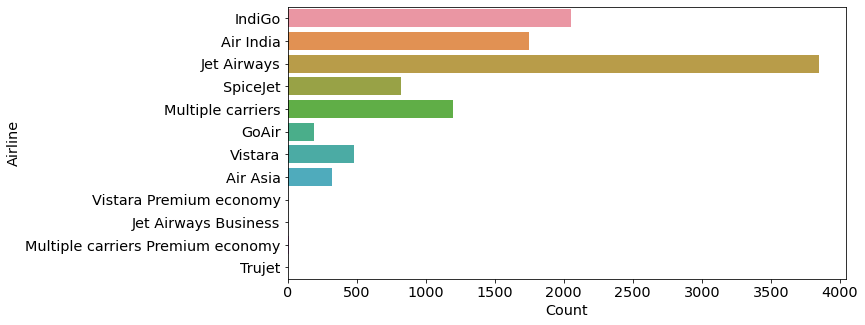

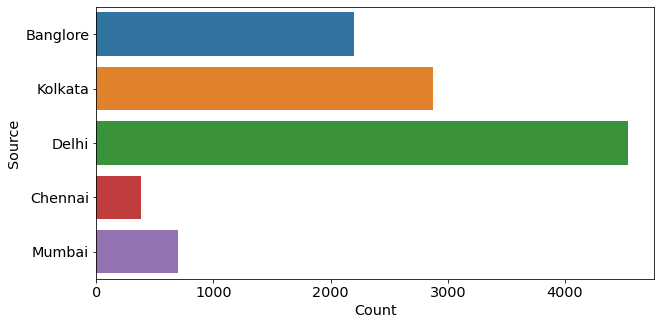

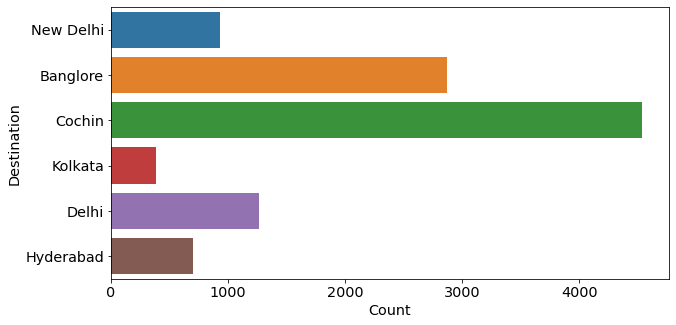

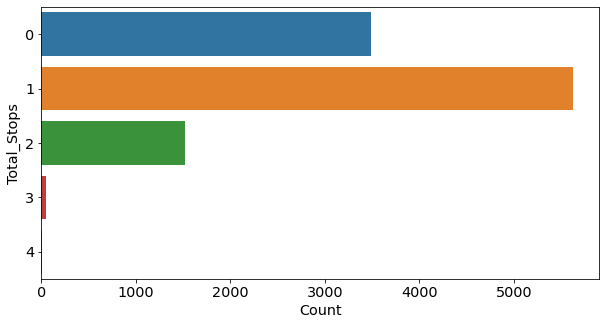

In [467]:
catlist = ['Airline', 'Source', 'Destination', 'Total_Stops']

for cols in catlist:
    plt.figure(figsize = (10,5))
    sns.countplot(data = df, y= cols)
    plt.xticks( fontsize='x-large')
    plt.yticks( fontsize='x-large')
    plt.xlabel('Count',fontsize = 'x-large')
    plt.ylabel(cols ,fontsize = 'x-large')
    plt.show()

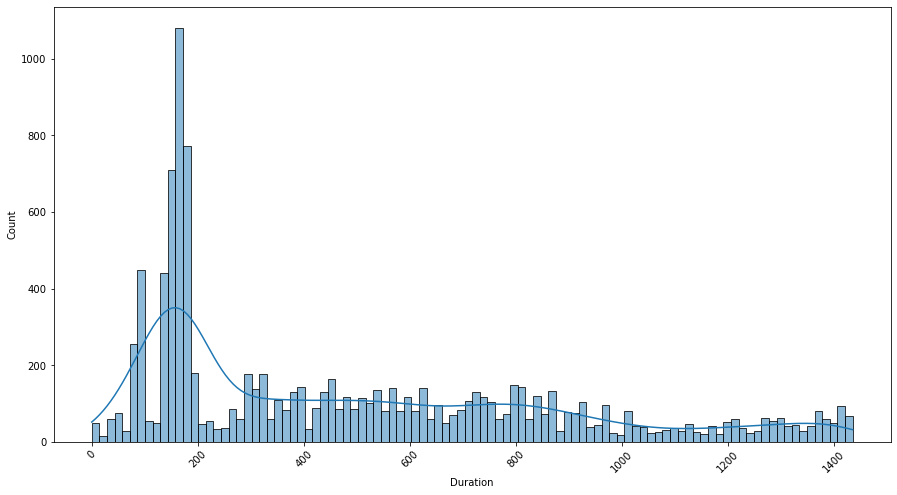

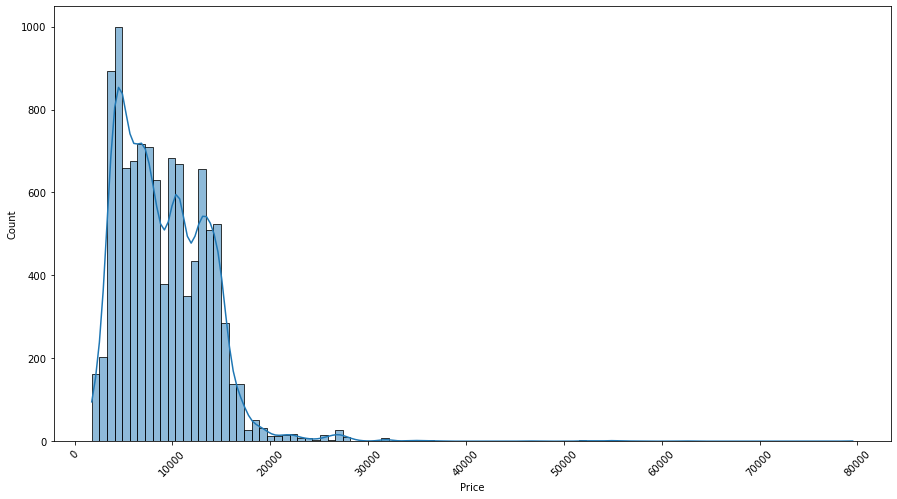

In [468]:
numlist = ['Duration', 'Price']
for cols in numlist:
    plt.figure(figsize = (15,8))
    sns.histplot( x = df[cols] , kde = True, bins = 100)
    plt.xticks(rotation = 45)
    plt.show()

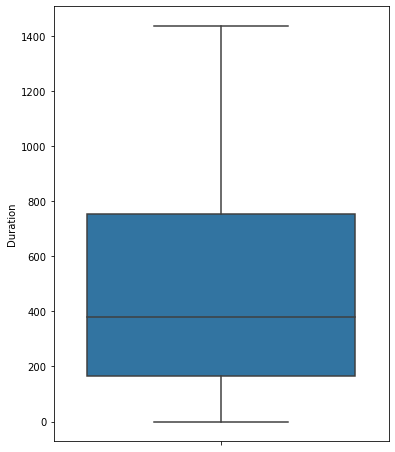

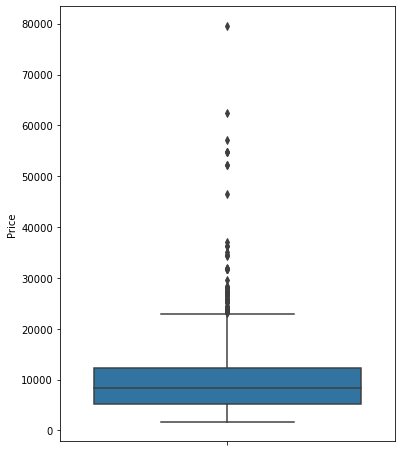

In [469]:

numlist = ['Duration', 'Price']
for cols in numlist:
    plt.figure(figsize = (6,8))
    sns.boxplot( y = df[cols] )
    plt.xticks(rotation = 45)
    plt.show()

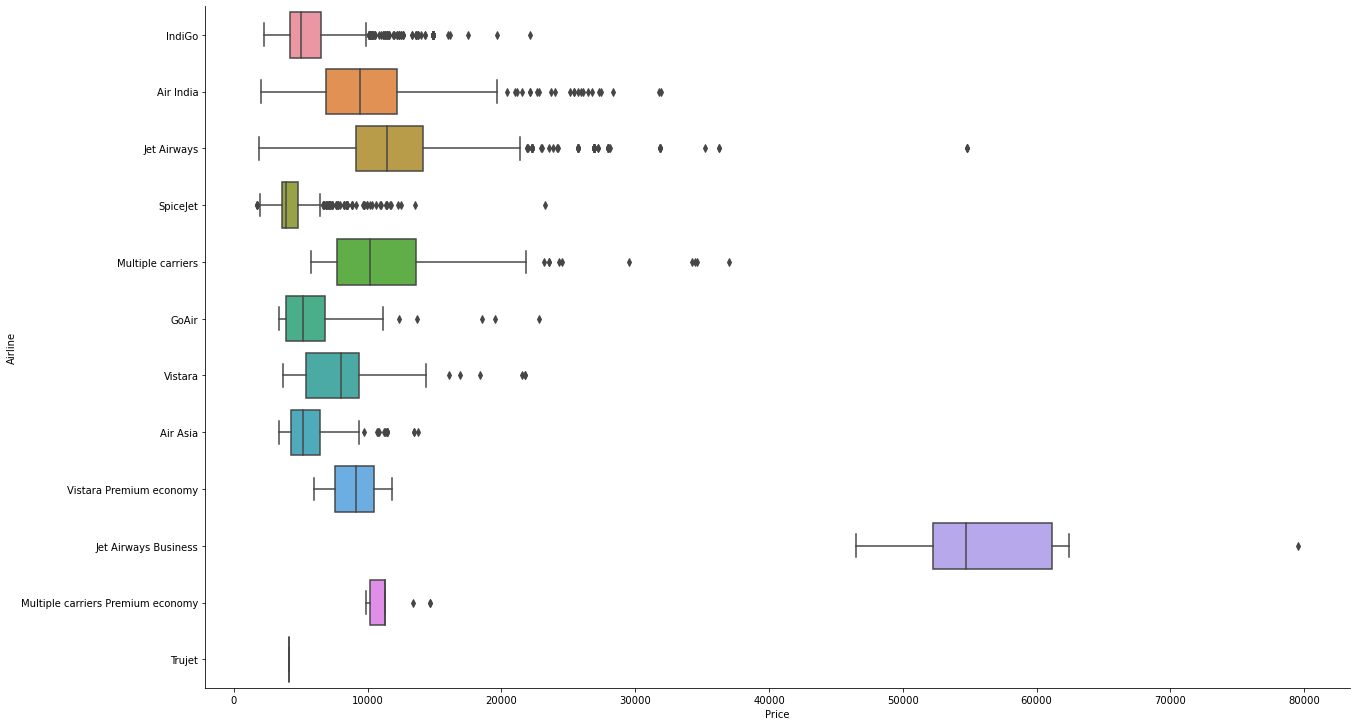

In [470]:
sns.catplot(data = df, y = 'Airline', x = 'Price', aspect = 15/8,kind = 'box' , height = 10)


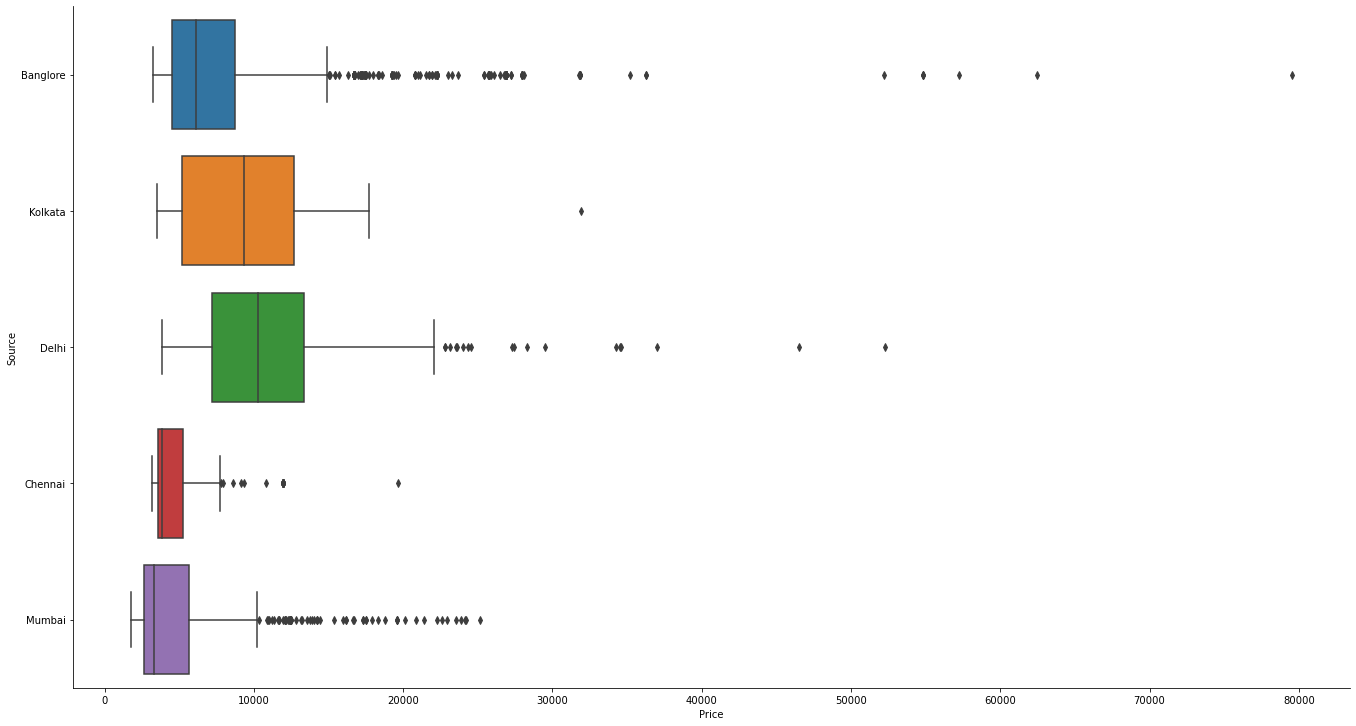

In [471]:
sns.catplot(data = df, y = 'Source', x = 'Price', aspect = 15/8,kind = 'box' , height = 10)


Text(-32.07500000000001, 0.5, 'Destination')

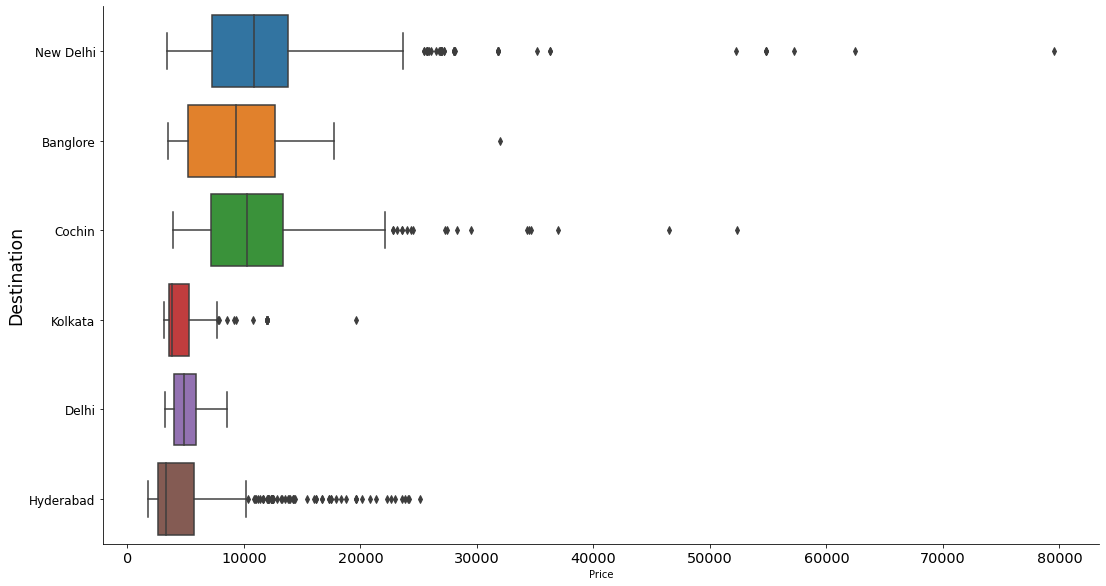

In [472]:
sns.catplot(data = df, y = 'Destination', x = 'Price', aspect = 15/8,kind = 'box' , height = 8)
plt.xticks(fontsize = "x-large")
plt.yticks(fontsize = "large")
plt.ylabel('Destination', fontsize = "xx-large")

In [473]:
df.pivot_table(index = ['Source', 'Destination'], aggfunc = {'Price':'mean'})

Price
Source   Destination              
Banglore Delhi         5143.918577
         New Delhi    11917.716738
Chennai  Kolkata       4789.892388
Delhi    Cochin       10539.439057
Kolkata  Banglore      9158.389411
Mumbai   Hyderabad     5059.708752

Prices for New Delhi and Delhi seem to be off a lot, and necessary to approach the stakeholders to clarify

Creating a copy adtaframe

In [474]:
copy_df = df.copy()

In [475]:
copy_df['Date_of_Journey_Year'] = copy_df['Date_of_Journey'].dt.year
copy_df['Date_of_Journey_Month'] = copy_df['Date_of_Journey'].dt.month
copy_df['Date_of_Journey_Day']  = copy_df['Date_of_Journey'].dt.day
copy_df['Date_of_Journey_WeekDay']  = copy_df['Date_of_Journey'].dt.weekday
copy_df['Date_of_Journey_Week']  = copy_df['Date_of_Journey'].dt.week
copy_df.drop(columns = 'Date_of_Journey', inplace = True)

<ipython-input-475-a2301bb19126>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  copy_df['Date_of_Journey_Week']  = copy_df['Date_of_Journey'].dt.week


In [476]:
copy_df.drop(columns = ['Route'], inplace = True)

In [477]:
copy_df = pd.get_dummies(copy_df)

Initializing the models

In [543]:
lin = LinearRegression()
las = Lasso()
rid = Ridge()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()
ada = AdaBoostRegressor()
grad = GradientBoostingRegressor()
extra = ExtraTreesRegressor()
models = [lin, las, rid, tree, forest, ada, grad, extra]
model_names = ['Linear regression', 'Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boost','Extra Trees']

In [544]:
X = copy_df.drop(columns = 'Price')
y = copy_df['Price']

In [523]:
cols = []
for model in models:
    cols.append(cross_val_score(model, X, y, cv= 5))


C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222207669.66104126, tolerance: 17933935.147090893
  model = cd_fast.enet_coordinate_descent(
C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414801848.0230789, tolerance: 17991036.027409036
  model = cd_fast.enet_coordinate_descent(
C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55311841.234687805, tolerance: 18181801.35722632
  model = cd_fast.enet_coordinate_descent(
C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

In [524]:
Cross_val_score = pd.DataFrame(dict(zip(model_names, cols)))


Cross Validation scores for the different models  

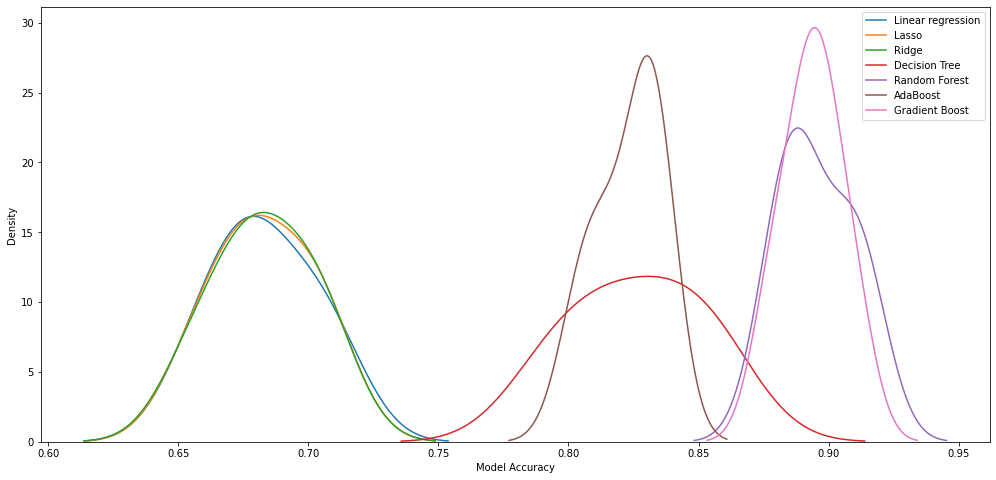

In [525]:
plt.figure(figsize   = (17,8))
for col in Cross_val_score.columns.tolist():
    if col =='AdaBoost':
        continue
    else:
        sns.kdeplot(x = Cross_val_score[col])
plt.legend(model_names)        
plt.xlabel('Model Accuracy')
plt.show()

Finding Hyperparameters

Ridge

In [511]:
params = {'alpha':np.logspace(-4, -1, 4)}
grid = RandomizedSearchCV(rid, param_distributions = params,cv = 5)
grid.fit(X,y)
grid.best_estimator_

In [517]:
rid = Ridge(alpha = 0.1)
cross_val_score(rid, X, y, cv = 5)

Random Forest

In [551]:
poly = PolynomialFeatures(2)
X_poly=poly.fit_transform(X)

In [555]:
cols = []
for model in models:
    cols.append(cross_val_score(model, X, y, cv= 5))
    print(model)


LinearRegression()


C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222207669.66104126, tolerance: 17933935.147090893
  model = cd_fast.enet_coordinate_descent(
C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414801848.0230789, tolerance: 17991036.027409036
  model = cd_fast.enet_coordinate_descent(
C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55311841.234687805, tolerance: 18181801.35722632
  model = cd_fast.enet_coordinate_descent(
C:\Users\prasad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

Lasso()
Ridge()
DecisionTreeRegressor()
RandomForestRegressor()
AdaBoostRegressor()
GradientBoostingRegressor()
ExtraTreesRegressor()


In [557]:
Cross_val_score1 = pd.DataFrame(dict(zip(model_names, cols)))


In [561]:
Cross_val_score.mean()

Linear regression    0.683193
Lasso                0.682767
Ridge                0.682786
Decision Tree        0.826238
Random Forest        0.895727
AdaBoost             0.279139
Gradient Boost       0.822921
Extra Trees          0.893858
dtype: float64

In [562]:
Cross_val_score1.mean()

Linear regression    0.683193
Lasso                0.682767
Ridge                0.682786
Decision Tree        0.818112
Random Forest        0.897522
AdaBoost             0.256125
Gradient Boost       0.823037
Extra Trees          0.894508
dtype: float64

There is some improvement after addition of Polynomial Features